<p align="center">
<img style="width:80%" src="https://c4.wallpaperflare
.com/wallpaper/378/267/803/titanic-ship-cruise-ship-drawing-night-hd-wallpaper-preview.jpg">
</p>

[Image source](https://www.wallpaperflare.com/titanic-ship-cruise-ship-drawing-night-hd-digital-artwork-wallpaper-mzpsf/)

<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Titanic.<br> Part 1.</h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/Classification/Titanic/Titanic.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1.   [Overview of data.](#step1)
## 2.	[Univariate feature analysis..](#step2)
## 3.	[Bivariate feature analysis.](#step3)

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
from pandas.api.types import is_numeric_dtype

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, \
    StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [59]:
pd.options.display.max_columns = 80
pd.options.display.max_rows = 30
pd.options.display.max_colwidth = 60

In [60]:
# Configure Matplotlib and seaborn
plt.style.use('seaborn-muted')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (16,5);
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = cm.tab10
blue = cmap.colors[0]
orange = cmap.colors[1]
green = cmap.colors[2]

In [61]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [blue, orange,
                                                             green])
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=60)

<ipython-input-61-00546e32499c>:3: UserWarning: Trying to register the cmap 'mycolormap' which already exists.
  matplotlib.cm.register_cmap("mycolormap", cmap)


<div id="step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Overview of data. </span>

## Load data

In [62]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv', index_col='PassengerId')
filled_df = pd.concat([train, test])
filled_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Missing data

In [63]:
def missing_data(dataset):
    import matplotlib
    cmap = matplotlib.cm.tab10
    green_hex = matplotlib.colors.to_hex(cmap.colors[2])

    missing_df = pd.DataFrame([dataset.isna().sum(), dataset.isna().sum() /
                               len(dataset)]).T
    missing_df.columns = ['Missing', 'MissingPercent']
    format_dict = {selected_column: "{:10,.2f}" for selected_column in
                   ['Missing', 'MissingPercent']}
    style = missing_df.style.apply(lambda x: [f'background-color: {green_hex}'
                                   for i in x])
    style.format(format_dict).bar\
        (subset=["Missing", 'MissingPercent'])
    return style

missing_data(filled_df)

,Missing,MissingPercent
Survived,418.00,0.32
Pclass,0.00,0.00
Name,0.00,0.00
Sex,0.00,0.00
Age,263.00,0.20
SibSp,0.00,0.00
Parch,0.00,0.00
Ticket,0.00,0.00
Fare,1.00,0.00
Cabin,"1,014.00",0.77


### Overall statistics of the DataFrame

In [64]:
def overall_statistics(df, features, columns=None):
    import matplotlib.colors
    blue_hex = matplotlib.colors.to_hex(blue)
    orange_hex = matplotlib.colors.to_hex(orange)
    green_hex = matplotlib.colors.to_hex(green)

    df_t = df.describe().T

    if columns is None:
        columns =  ['count', 'min', 'mean', 'max', 'std']
    df_stats = df_t.loc[features, columns]
    df_stats.sort_values('mean', inplace=True, ascending=False)
    df_stats['dtype'] = df[features].dtypes.astype('str')
    format_dict = {column: "{:10,.2f}" for column in columns}
    return df_stats.style.format(format_dict)\
                     .bar(subset=["mean"], color=green_hex)\
                     .bar(subset=["max"], color=blue_hex)\
                     .bar(subset=["std"], color=orange_hex)

features = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Survived']
overall_statistics(filled_df, features, columns=None)

,count,min,mean,max,std,dtype
Fare,"1,308.00",0.00,33.30,512.33,51.76,float64
Age,"1,046.00",0.17,29.88,80.00,14.41,float64
Pclass,"1,309.00",1.00,2.29,3.00,0.84,int64
SibSp,"1,309.00",0.00,0.50,8.00,1.04,int64
Parch,"1,309.00",0.00,0.39,9.00,0.87,int64
Survived,891.00,0.00,0.38,1.00,0.49,float64


## <span style="color:#01872A;display: block; font-style: italic;padding:10px; background:#daf2e1;border-radius:20px; text-align: left; font-size: 30px; "> Step 1 results: </span>

1. Lots of missing data in **Cabin and Age** columns. Need to consider
imputing strategies.
2. Magnitude of feature values is quite different, so scaling will be needed
for non-tree-based models.

<div id="step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Univariate feature analysis. </span>

## Function to plot numbers on bars

In [65]:
def autolabel(rects, ax, decimals=2, inside=False, old_rects=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for index, rect in enumerate(rects):
        height = rect.get_height()
        value = round(height, decimals)
        if inside:
            height = height / 2
        if old_rects:
            height += old_rects[index].get_height()
        ax.annotate('{}'.format(value),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    size=18,# 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

### Feature distributions

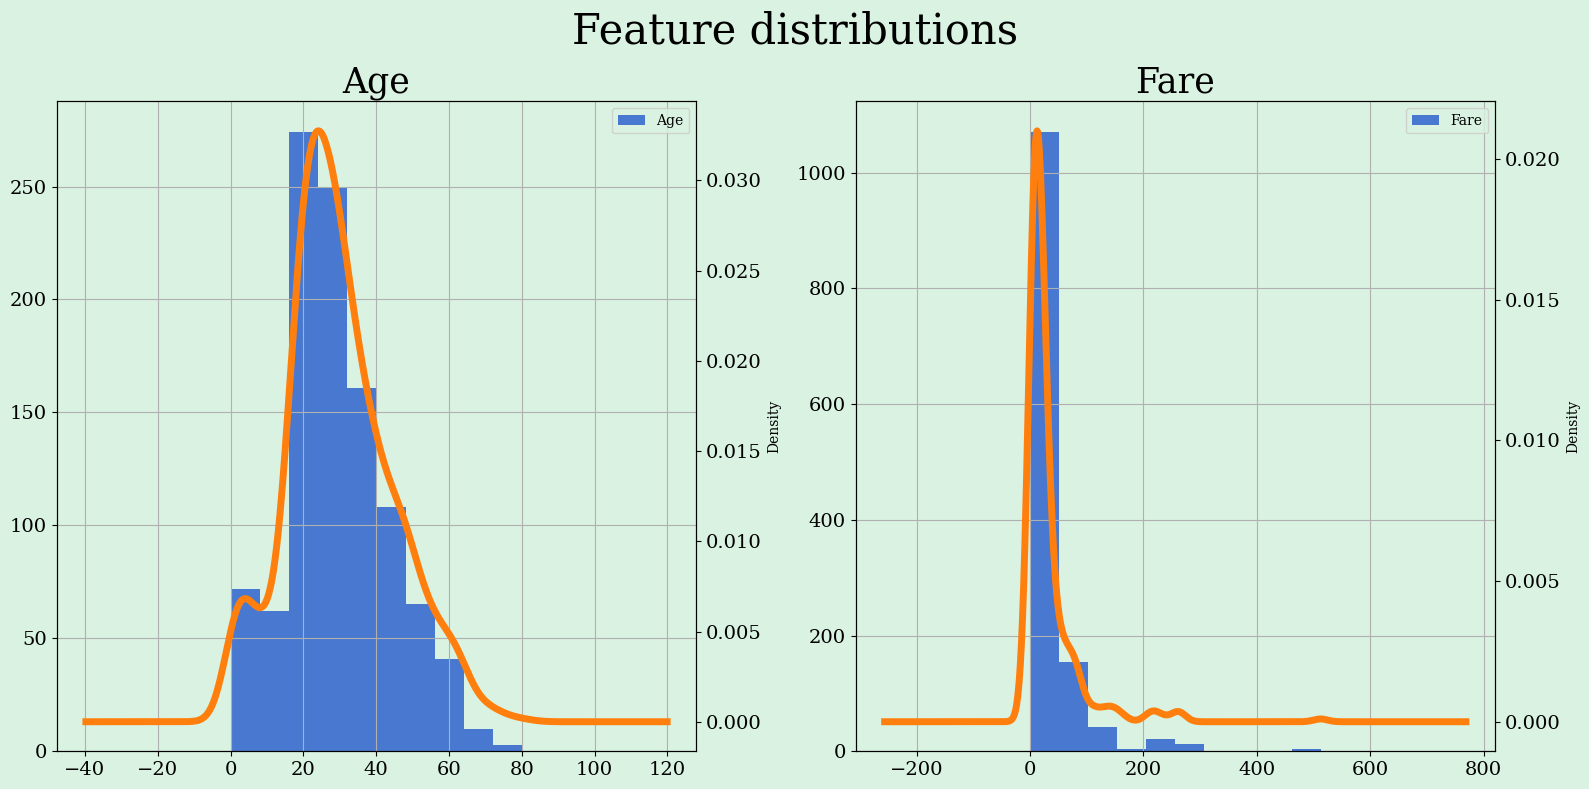

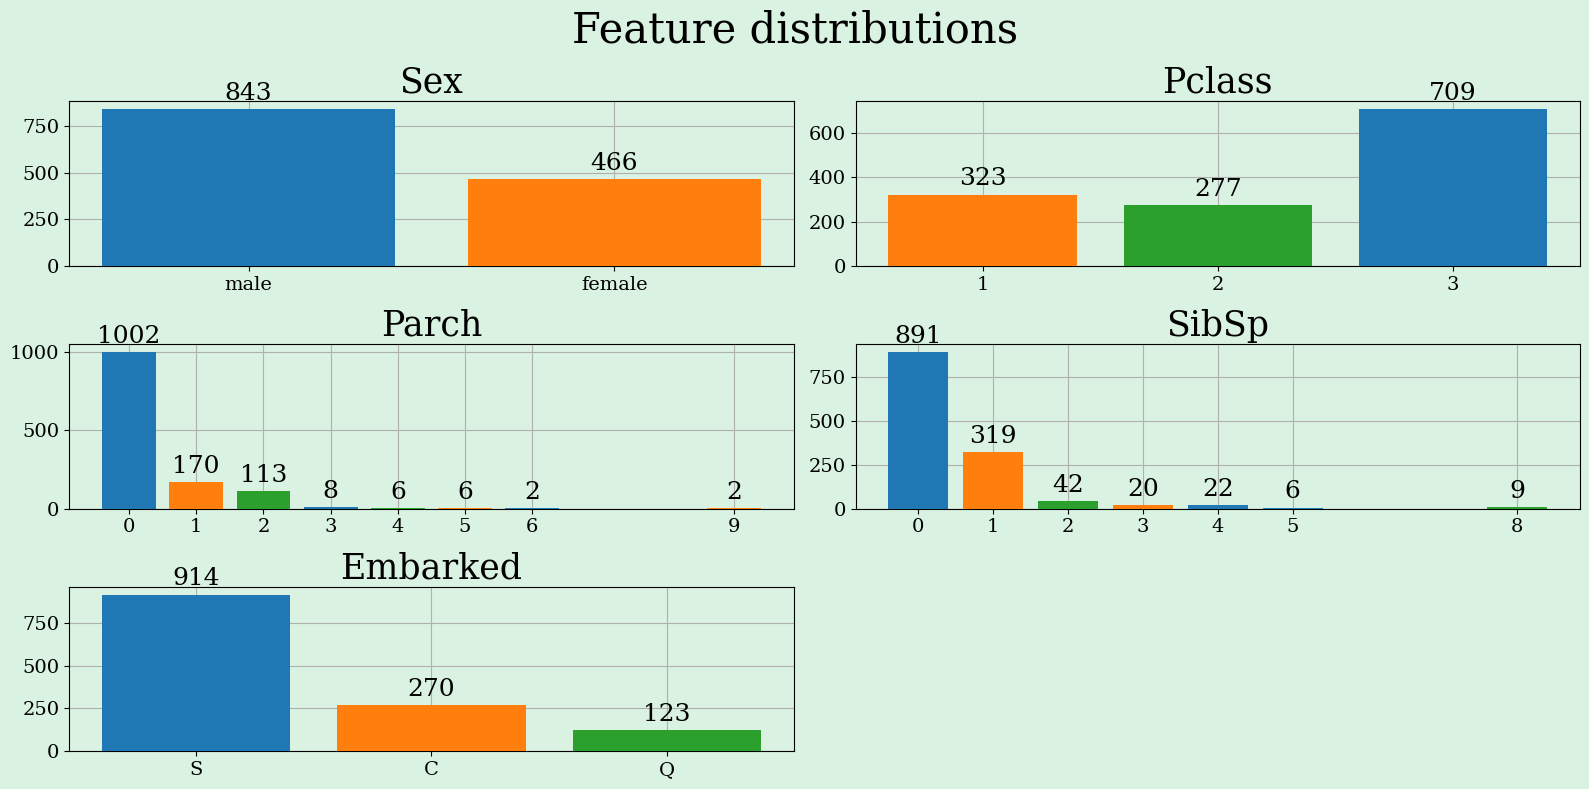

In [66]:
def feature_distibutions(df, columns=None, type='hist'):
    if columns is None:
        columns = df.columns.tolist()

    plot_columns = 2
    plot_rows = int(np.ceil(len(columns) / plot_columns))
    fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(16, 8))
    if type == 'hist':
        df[columns].hist(ax=axes.ravel()[:len(columns)],
                                     legend=True)
        df[columns].plot(kind='kde', secondary_y=True, subplots=True,
                         ax=axes.ravel()[:len(columns)], color=orange,
                         legend=False)
    elif type == 'bar':
        for column, ax in zip(columns, axes.ravel()):
            bar_values = df[column].value_counts()
            rects = ax.bar(bar_values.index, bar_values,
                           color=[blue, orange, green], zorder=3)
            autolabel(rects, ax)
            ax.set_title(column)
            ax.set_xticks(bar_values.index)
    if len(columns) / plot_columns != int(len(columns) / plot_columns):
        last_ax = axes.ravel()[-1]
        last_ax.axis('off')
    plt.suptitle('Feature distributions')
    plt.tight_layout()
    plt.show()
feature_distibutions(filled_df, columns=['Age', 'Fare'], type='hist')
feature_distibutions(filled_df, columns=['Sex', 'Pclass', 'Parch', 'SibSp',
                                         'Embarked'], type='bar')

### Dependent variable distributions


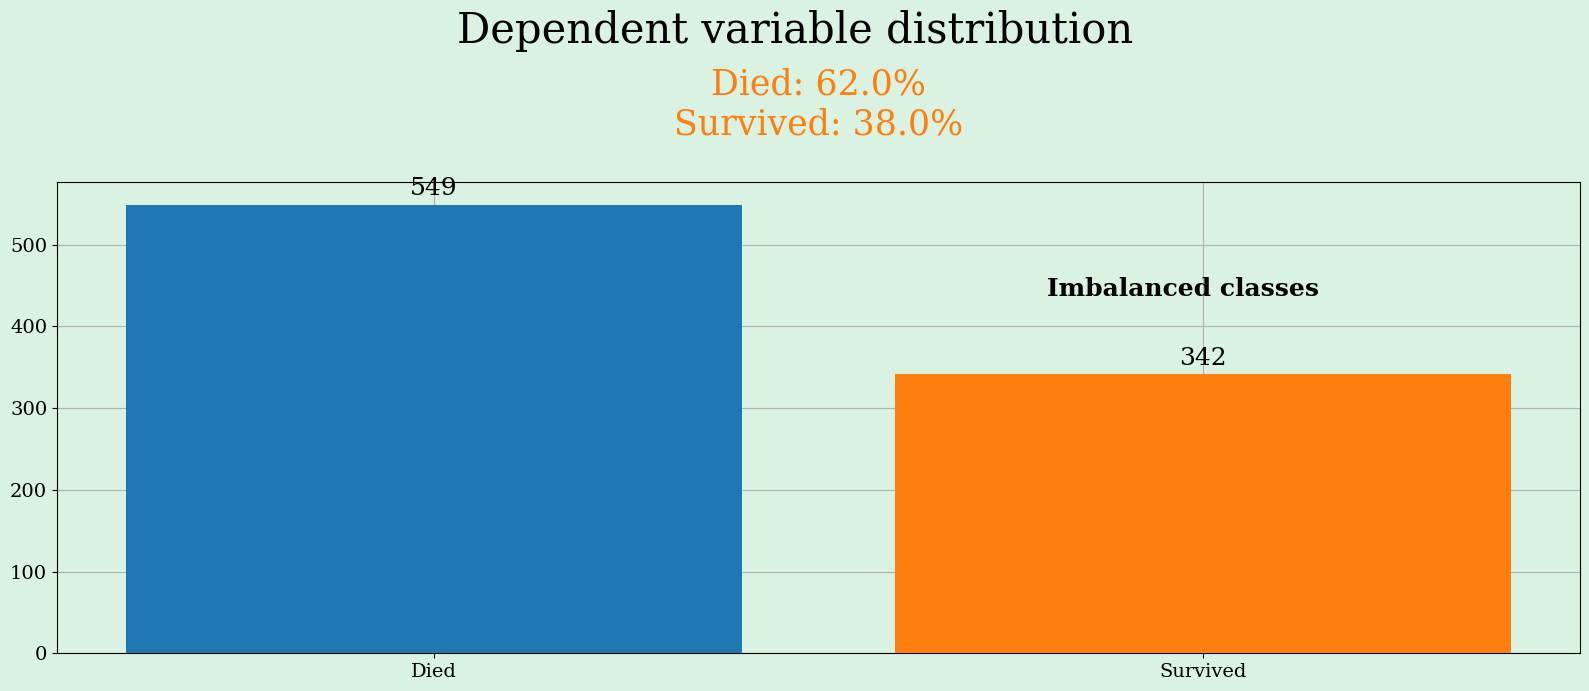

In [67]:
died_survived_counts = filled_df['Survived'].value_counts()
died_survived_counts.index = ['Died', 'Survived']
died_survived_percent = \
    filled_df['Survived'].value_counts(normalize=True).apply(round, args=(2,))
died_survived_percent.index = ['Died', 'Survived']
fig, ax = plt.subplots(figsize=(16, 7))
fig.suptitle('Dependent variable distribution')
rects = ax.bar(died_survived_counts.index, died_survived_counts.values,
               color=[blue, orange], zorder=3)
ax.set_xticks([0, 1])
ax.set_title(f'Died: {died_survived_percent["Died"] * 100}%\n'
              f'Survived: {died_survived_percent["Survived"] * 100}%\n', color=orange)
ax.text(0.65, 0.70, f'Imbalanced classes\n',
             transform = ax.transAxes, size=18, fontweight='bold')
autolabel(rects, ax, decimals=2)
plt.tight_layout()
plt.show()

### Compare feature distributions of different classes (Died vs. Survived)

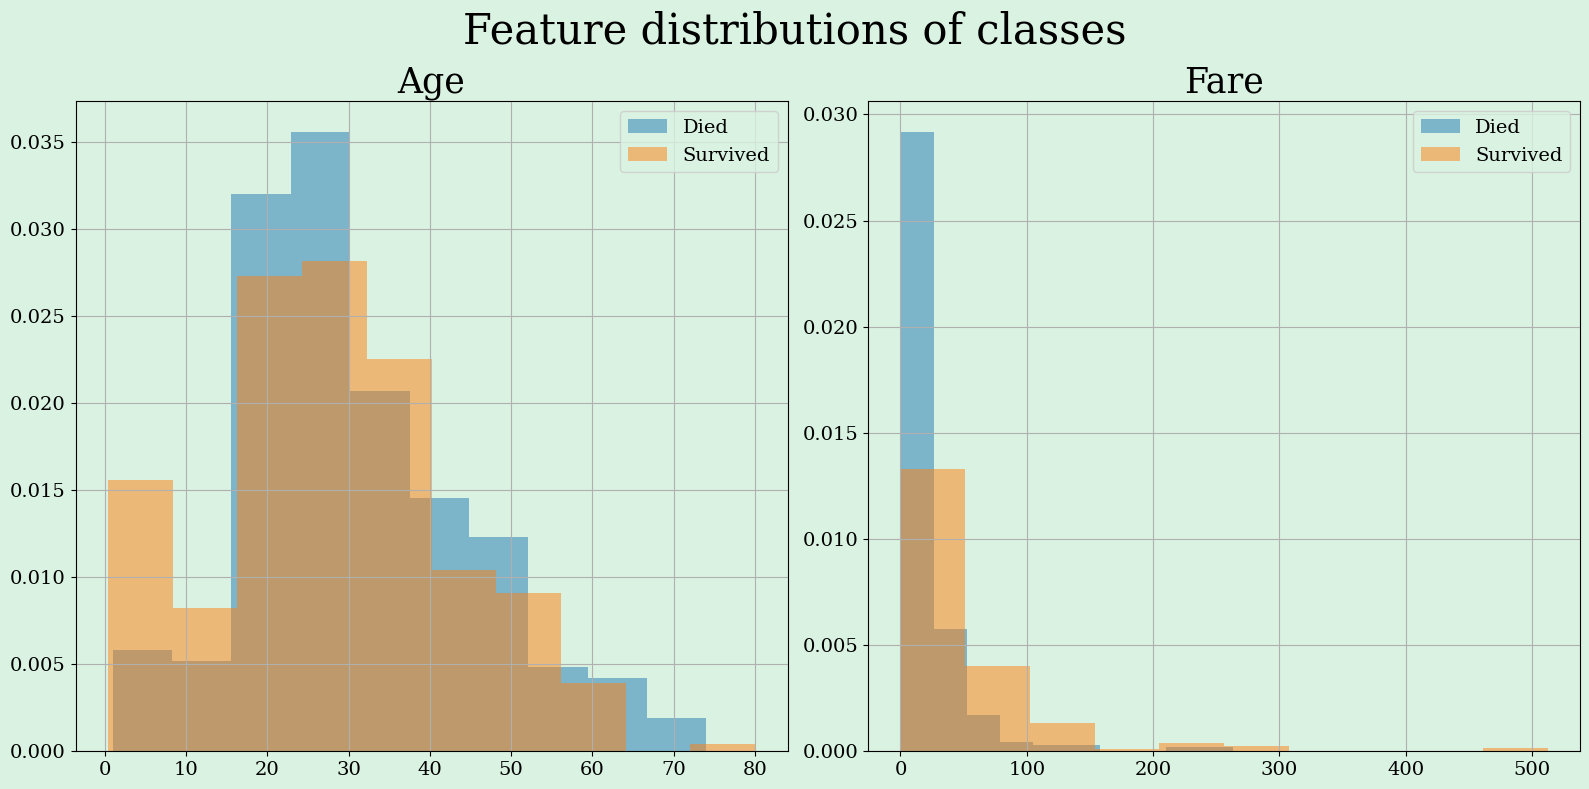

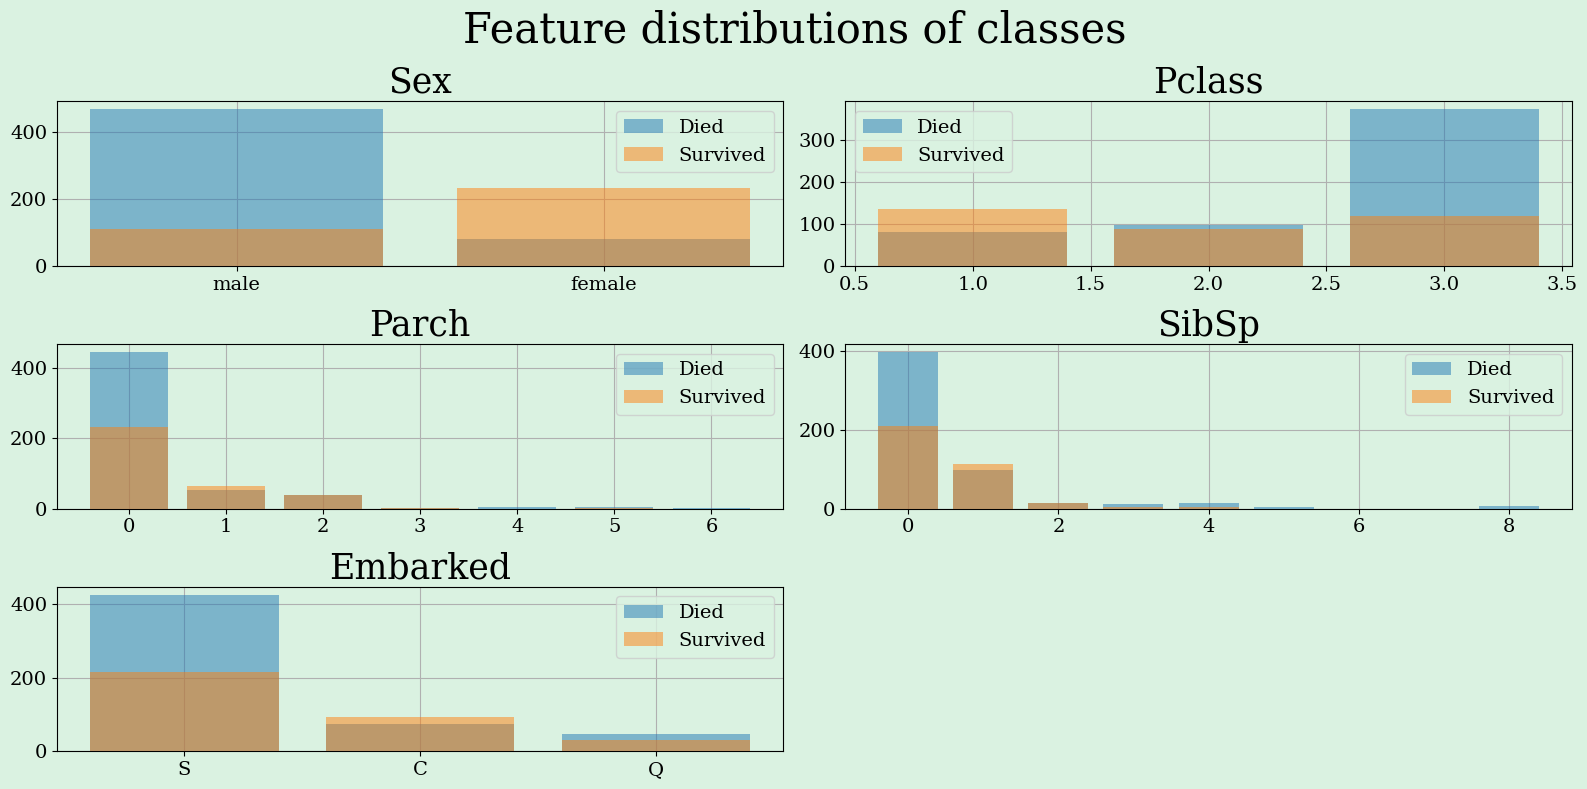

In [68]:
def compare_distributions(df, columns, dependent_variable, classes,
                          type='hist'):
    classes_dict = {}
    for class_name, class_value in classes.items():
        classes_dict[class_name] = \
            df[df[dependent_variable] == class_value][columns]
    colors = [blue, orange]
    plot_columns = 2
    plot_rows = int(np.ceil(len(columns) / plot_columns))
    fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(16, 8))
    for column, ax in zip(columns, axes.ravel()):
        color_number = 0
        if type == 'hist':
            for class_name, class_rows in classes_dict.items():
                ax.hist(class_rows[column], density=True, alpha = 0.5,
                        label=class_name, color=colors[color_number])
                color_number += 1
            ax.legend(fontsize=14)
        elif type == 'bar':
            for class_name, class_rows in classes_dict.items():
                bar_values = class_rows[column].value_counts()
                ax.bar(bar_values.index, bar_values, color=colors[color_number],
                    zorder=3, alpha = 0.5, label=class_name)
                color_number += 1
            ax.legend(fontsize=14)
        ax.set_title(column)
    if len(columns) / plot_columns != int(len(columns) / plot_columns):
        last_ax = axes.ravel()[-1]
        last_ax.axis('off')
    plt.suptitle('Feature distributions of classes')
    plt.tight_layout()
    plt.show()
classes = {'Died': 0, 'Survived': 1}
compare_distributions(filled_df, columns=['Age', 'Fare'], type='hist',
                      dependent_variable='Survived', classes=classes)
compare_distributions(filled_df, columns=['Sex', 'Pclass', 'Parch', 'SibSp',
                                          'Embarked'],
                      type='bar', dependent_variable='Survived',
                      classes=classes)

## <span style="color:#01872A;display: block; font-style: italic;padding:10px; background:#daf2e1;border-radius:20px; text-align: left; font-size: 30px; "> Step 2 results: </span>
2. **Age and Fare** distributions are not normal.
3. Classes are **imbalanced**.
4. Passengers with sex = 'Male' and Pclass = '3' are less likely to survive.
5. Large families are less likely to survive, at the same time alone
passengers are less likely to survive either.
6. Passengers embarked at **'S'** are less likely to survive.


<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 3. Bivariate feature analysis <br>  (analysis of pairs of features). </span>

Encode 'Sex' to check correlation and fill missing values

In [69]:
encoded_df = filled_df.copy()
encoder = LabelEncoder()
encoded_df['Sex'] = encoder.fit_transform(encoded_df['Sex'])
encoded_df['Embarked'] = encoded_df['Embarked'].fillna('S')
encoded_df['Age'] = encoded_df['Age'].fillna(encoded_df['Age'].mean())
encoded_df['Cabin'] = encoded_df['Cabin'].fillna('Unknown')

## Check correlation of features with dependent variable.

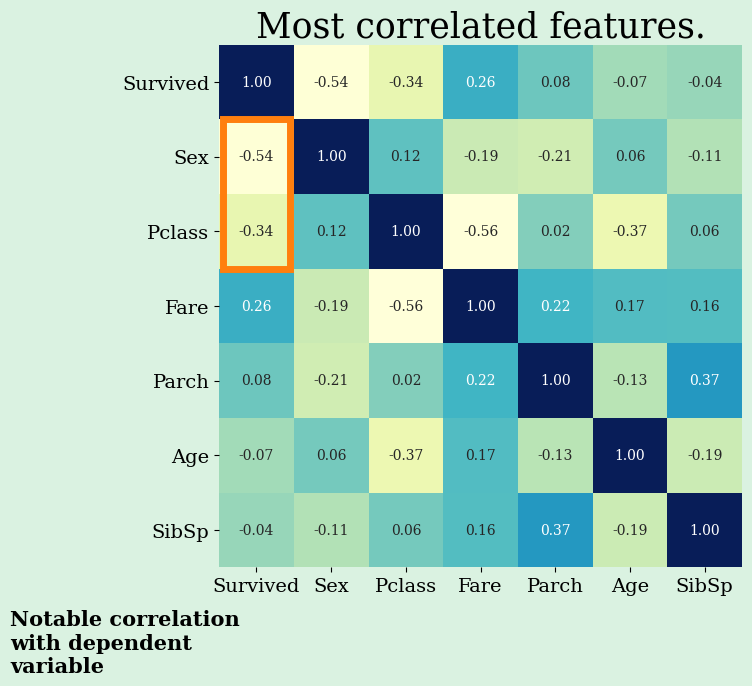

In [70]:
def plot_correlated_features(df, dependent_variable, min_threshold=None):
    import matplotlib.patches as patches

    corr = df.corr()
    sorted_index = \
        corr[dependent_variable].apply(np.abs).sort_values(ascending=False).index
    sorted_corr = corr[sorted_index].reindex(sorted_index)
    if min_threshold is not None:
        most_correlated_index = \
            sorted_corr[(sorted_corr.iloc[:, 0] >=min_threshold) |
                        (sorted_corr.iloc[:, 0] <= -min_threshold)].index
        sorted_corr = sorted_corr.loc[most_correlated_index, most_correlated_index]

    fig, ax = plt.subplots(figsize=(14, 7))
    sns.heatmap(sorted_corr, ax=ax, annot=True, fmt='.2f',
                cmap='YlGnBu',
                cbar=False,
                square=True)
    ax.set_title('Most correlated features.')
    ax.text(-0.4, -0.2, 'Notable correlation\nwith dependent\nvariable',
           transform = ax.transAxes, size=15, fontweight='bold')
    rect = patches.Rectangle((0.05, 1), 0.9, 2, linewidth=5, edgecolor=orange,
                             facecolor='none')
    ax.add_patch(rect)
    plt.tight_layout()
    plt.show()
plot_correlated_features(encoded_df, 'Survived', min_threshold=None)

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Pairplots for numerical features.</h3>

In [71]:
columns = ['Fare', 'Age', 'Survived']

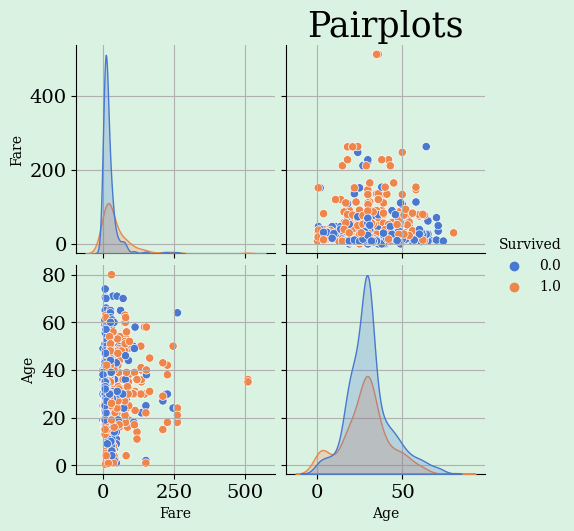

In [72]:
axes = sns.pairplot(encoded_df[:len(train)][columns], hue='Survived')
plt.title('Pairplots')
plt.show()

In [73]:
class_sex = pd.crosstab(filled_df['Pclass'], filled_df['Sex'],
                        normalize='index')
class_sex.reset_index(inplace=True)
class_sex.columns = ['Pclass', 'Female', 'Male']

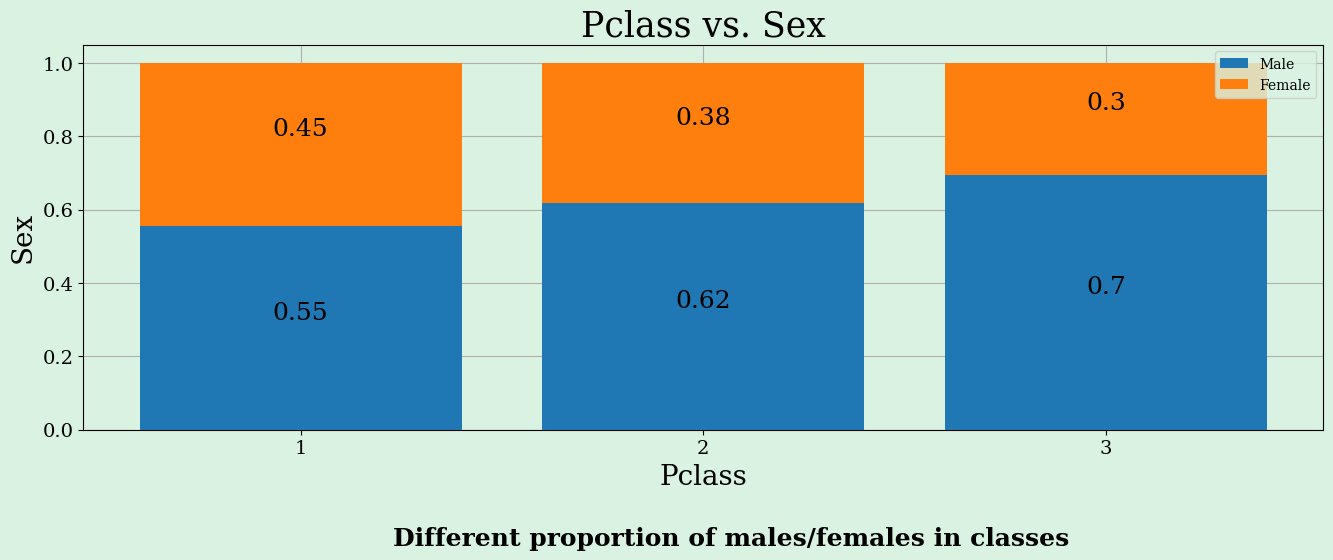

In [74]:
def categorical_plot(df, horizontal_feature, vertical_feature,
                     vertical_classes, bottom_text=None, labels=False):
    bottom = 0
    old_rects = None
    fig, ax = plt.subplots()
    for index, vertical_class in enumerate(vertical_classes):
        p1 = ax.bar(df[horizontal_feature], df[vertical_class],
                    label=vertical_class, color=cm.tab10.colors[index],
                    zorder=3, bottom=bottom)
        bottom += df[vertical_class]
        if labels:
            autolabel(p1, ax, inside=True, old_rects=old_rects)
            if old_rects is None:
                old_rects = p1
            else:
                old_rects += p1
    ax.set_xlabel(horizontal_feature, size=20)
    ax.set_ylabel(vertical_feature, size=20)
    ax.set_xticks(df[horizontal_feature])
    ax.set_title(f'{horizontal_feature} vs. {vertical_feature}')
    ax.legend()
    if bottom_text:
        ax.text(0.25, -0.30, bottom_text, transform = ax.transAxes, size=18,
                fontweight='bold')
    plt.show()

categorical_plot(class_sex, horizontal_feature='Pclass',
                 vertical_feature='Sex', vertical_classes=['Male', 'Female'],
                 bottom_text='Different proportion of males/females in '
                             'classes',
                 labels=True)

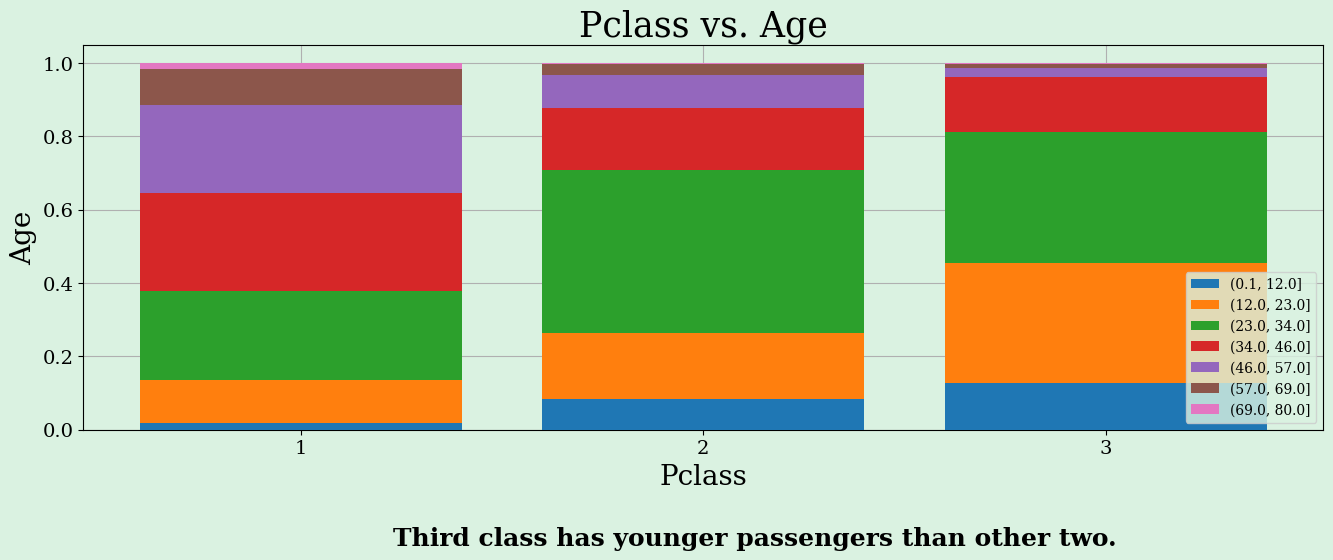

In [75]:
age_binned, bins = pd.cut(filled_df['Age'], 7, precision=0, retbins=True)
class_age = pd.crosstab(filled_df['Pclass'], age_binned, normalize='index')
class_age.reset_index(inplace=True)

categorical_plot(class_age, horizontal_feature='Pclass',
                 vertical_feature='Age',
                 vertical_classes=class_age.columns.drop('Pclass'),
                 bottom_text='Third class has younger passengers than other '
                             'two.')

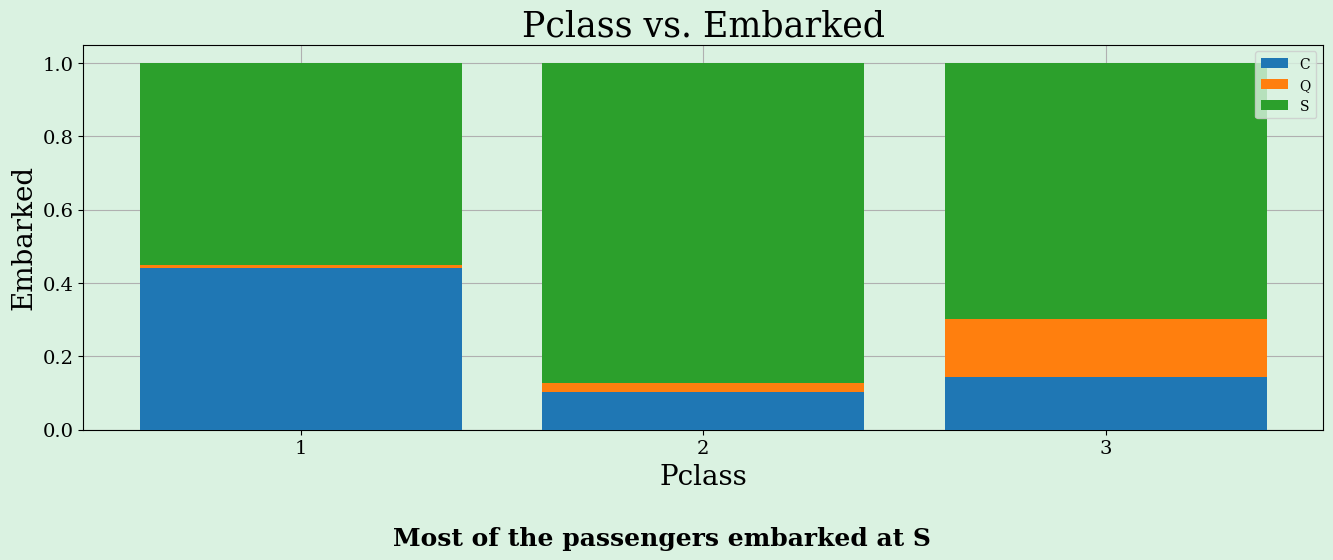

In [76]:
class_embarked = pd.crosstab(filled_df['Pclass'], filled_df['Embarked'],
                             normalize='index')
class_embarked.reset_index(inplace=True)
categorical_plot(class_embarked, horizontal_feature='Pclass',
                 vertical_feature='Embarked',
                 vertical_classes=class_embarked.columns.drop('Pclass'),
                 bottom_text='Most of the passengers embarked at S')

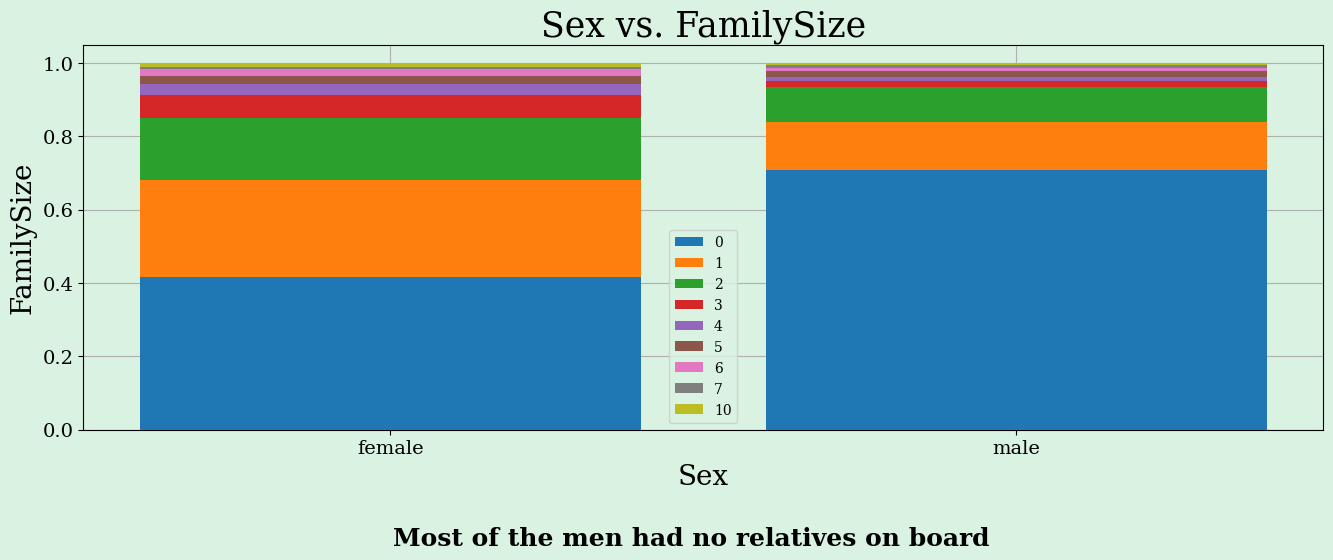

In [77]:
sex_family_size = pd.crosstab(filled_df['Sex'], filled_df['SibSp'] +
                              filled_df['Parch'], normalize='index')
sex_family_size.reset_index(inplace=True)
categorical_plot(sex_family_size, horizontal_feature='Sex',
                 vertical_feature='FamilySize',
                 vertical_classes=sex_family_size.columns.drop('Sex'),
                 bottom_text='Most of the m'
                             'en had no relatives on board')

## <span style="color:#01872A;display: block; font-style: italic;padding:10px; background:#daf2e1;border-radius:20px; text-align: left; font-size: 30px; "> Step 3 results: </span>

1. The only strong correlation of dependent varible is **'Sex'** feature.
2. Features 'Fare' and 'Pclass' are correlated with each other as expected,
both have some correlation with dependent variable.
3. Features connected with family have little direct correlation with dependent
variable.

## Part 2. Feature engineering:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/Classification/Titanic/Titanic.ipynb

## Part 3. Model selection:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/Classification/Titanic/Titanic.ipynb
